<p style="font-family:Verdana; font-size: 26px; color: magenta"> 7.0 - Ola Bike Ride Request Forecast using ML</p>

<p style="font-family:Verdana; font-size: 18px; color: orange"> We are talking about online cab and bike facility providers like OLA and Uber  </p> 
<p style="font-family:Verdana; font-size: 18px; color: orange"> If you had used this app some times then you must have paid some day less and someday more for the same journey</p> 
<p style="font-family:Verdana; font-size: 18px; color: magenta"> 1. season</p>
<p style="font-family:Verdana; font-size: 18px; color: magenta"> 2. weather</p>
<p style="font-family:Verdana; font-size: 18px; color: magenta"> 3. casual</p>
<p style="font-family:Verdana; font-size: 18px; color: magenta"> 4. registered</p>
<p style="font-family:Verdana; font-size: 18px; color: magenta"> 5. count </p>

<p style="font-family:Verdana; font-size: 18px; color: orange"> Step 1: Import Libraries</p>

In [300]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse, r2_score
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
import joblib
import warnings
warnings.filterwarnings('ignore')

<p style="font-family:Verdana; font-size: 20px; color: orange"> Step 2: Loading the Data</p>

In [301]:
try:
    df = pd.read_csv('../../data/ola.csv')
except Exception as e:
    print(f"Error loading dataset: {e}")
 
df.head(3)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349


In [302]:
pd.set_option('display.max_rows', 5)
display(df.head(3))

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349


In [303]:
print("Dataset Shape:", df.shape)
df.info()
df.describe().T

Dataset Shape: (730, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


,count,mean,std,min,25%,50%,75%,max
instant,730.0,365.500000,210.877136,1.0,183.25,365.5,547.75,730.0
season,730.0,2.498630,1.110184,1.0,2.00,3.0,3.00,4.0
...,...,...,...,...,...,...,...,...
registered,730.0,3658.757534,1559.758728,20.0,2502.25,3664.5,4783.25,6946.0
cnt,730.0,4508.006849,1936.011647,22.0,3169.75,4548.5,5966.00,8714.0


<p style="font-family:Verdana; font-size: 20px; color: orange"> Step 3: Feature Engineering</p>

In [304]:
df['dteday'] = pd.to_datetime(df['dteday'], format='%d-%m-%Y')

In [305]:
df['day'] = df['dteday'].dt.day
df['month'] = df['dteday'].dt.month
df['year'] = df['dteday'].dt.year
df['weekday'] = df['dteday'].dt.weekday

In [306]:
df['holidays'] = df['holiday'].apply(lambda x: 1 if x == 1 else 0)

In [307]:
df.drop(['instant', 'dteday', 'holiday'], axis=1, inplace=True)

In [310]:
print(df.isnull().sum())

season      0
yr          0
           ..
year        0
holidays    0
Length: 17, dtype: int64


In [ ]:
# from holidays import country_holidays

# def is_holiday(x):

#     estonia_holidays = country_holidays("EE", years=range(2011, 2013), language="en_US")

#     if estonia_holidays.get(x):
#         return 1
#     else:
#         return 0


# df['holidays'] = df['date'].apply(is_holiday)
# df.iloc[23:25]

from holidays import country_holidays
# estonia_holidays = country_holidays("EE", years=range(2011, 2012), language="en_US")
for dt, name in sorted(country_holidays("EE", years=2011, language="en_US").items()):
    print(dt, name)

<p style="font-family:Verdana; font-size: 20px; color: orange"> Step 3: Exploratory Data Analysis</p>

In [ ]:
# EDA is an approach to analyzing the data using visual techniques. It is used to discover trends, and patterns, or to check
# To check the null values in the dataset.
for col in df.columns:
    temp = df[col].isnull().sum()
    if temp > 0:
        print(f'Column {col} contains {temp} null values.') 

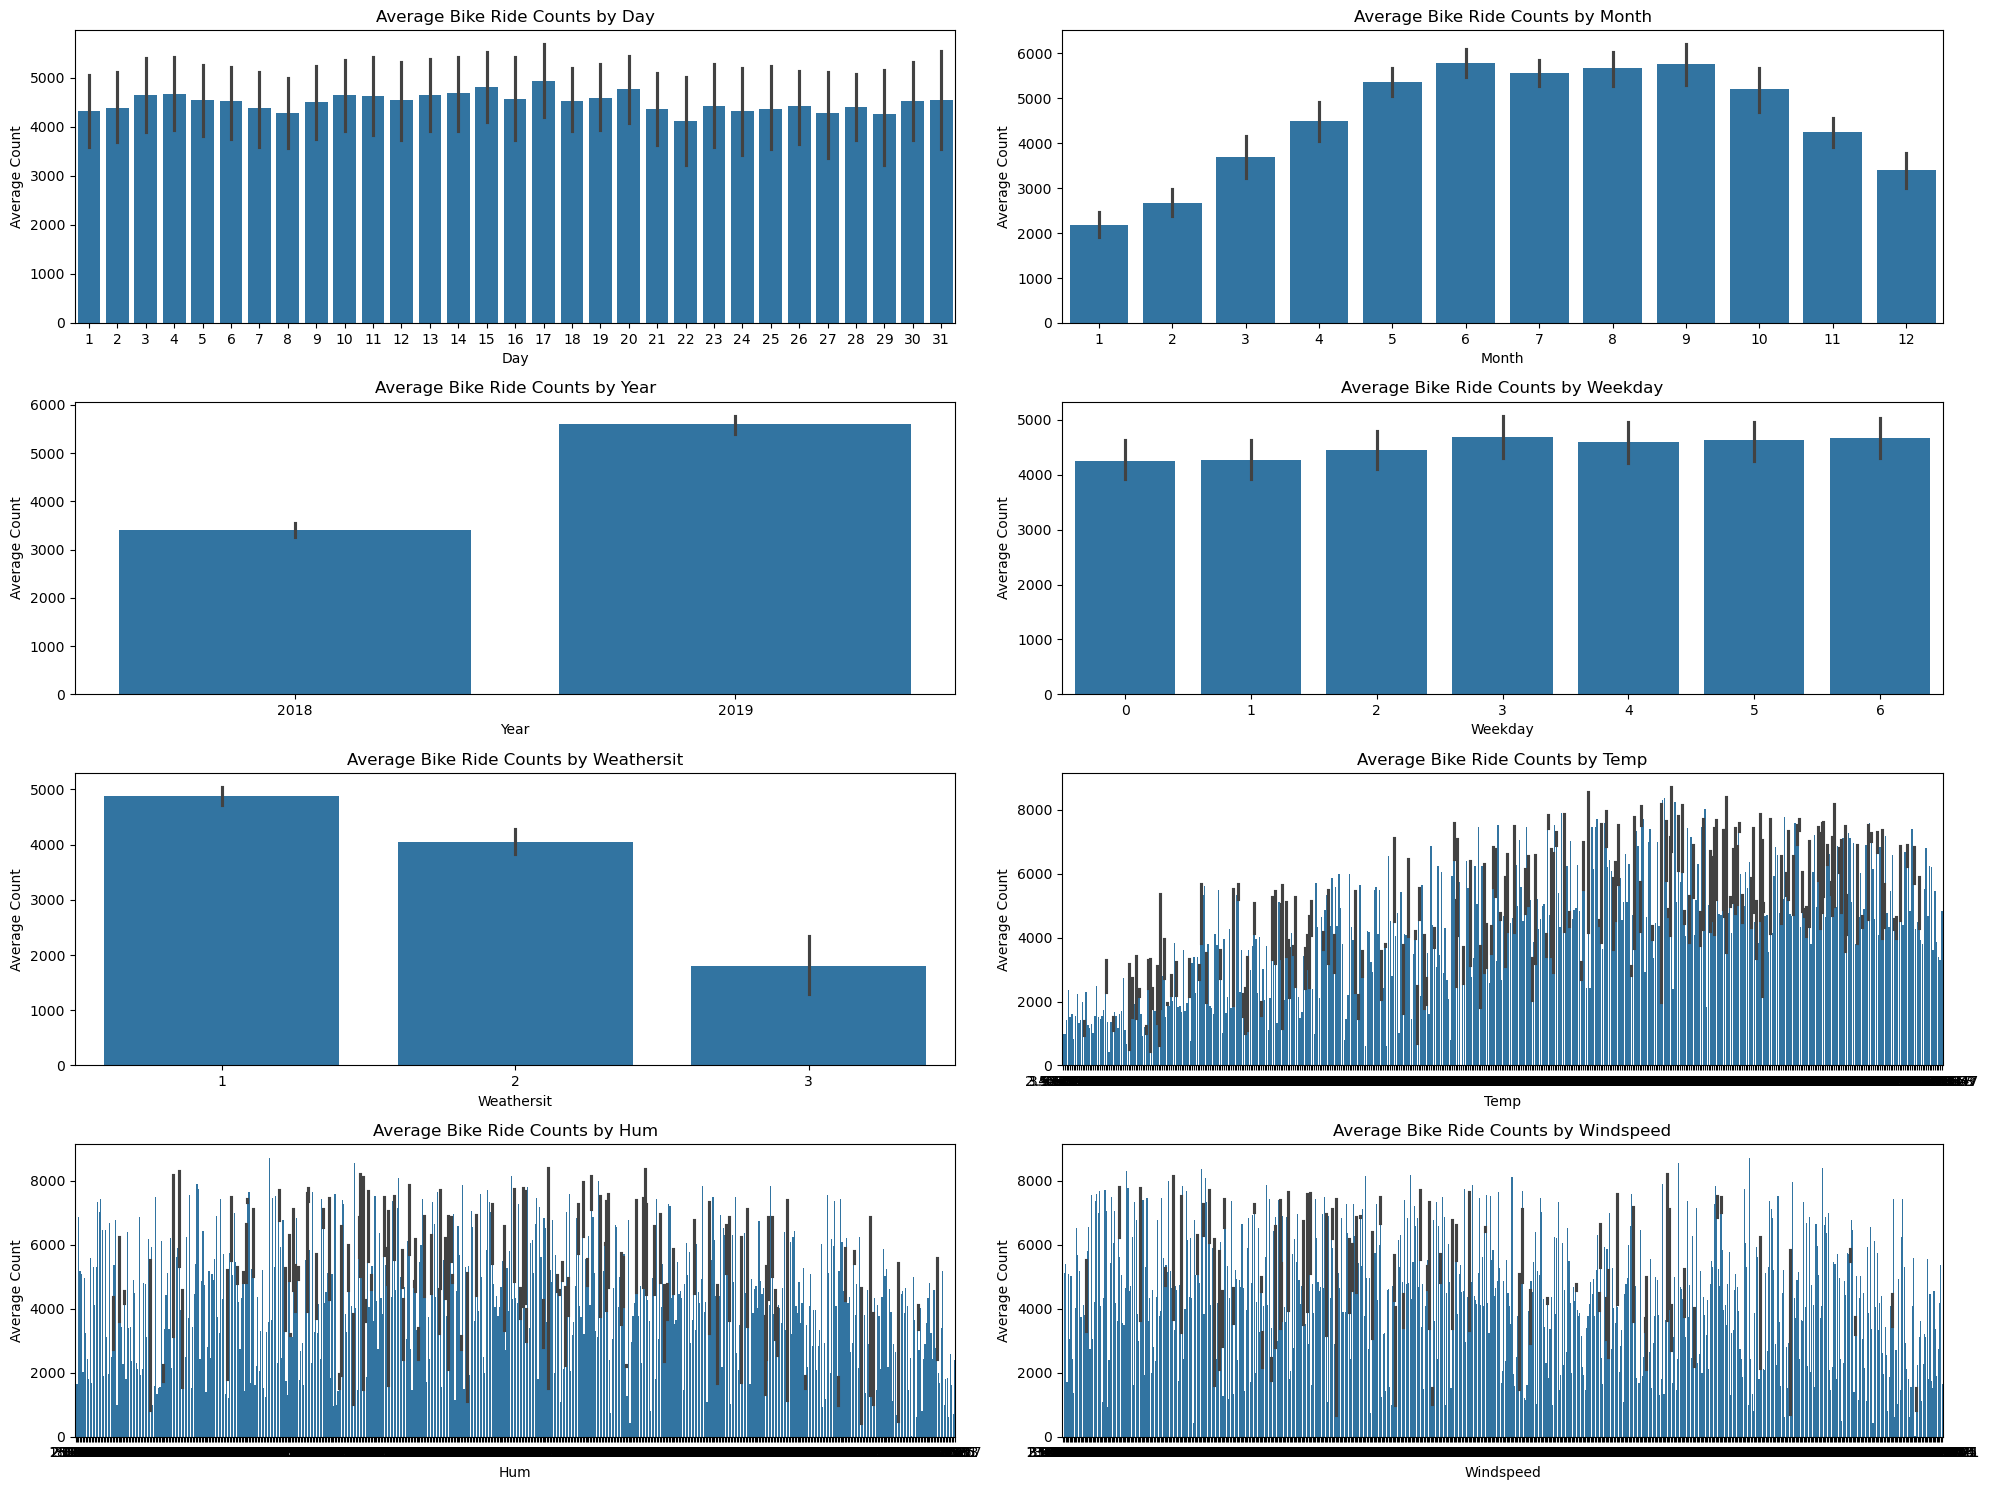

In [314]:
features_to_plot = ['day', 'month', 'year', 'weekday', 'weathersit', 'temp', 'hum', 'windspeed']
plt.figure(figsize=(20, 15))

for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(4, 2, i)
    sb.barplot(x=feature, y='cnt', data=df, estimator=np.mean)
    plt.title(f'Average Bike Ride Counts by {feature.capitalize()}')
    plt.xlabel(feature.capitalize())
    plt.ylabel('Average Count')

plt.tight_layout()
plt.show()

<Figure size 1500x1000 with 0 Axes>

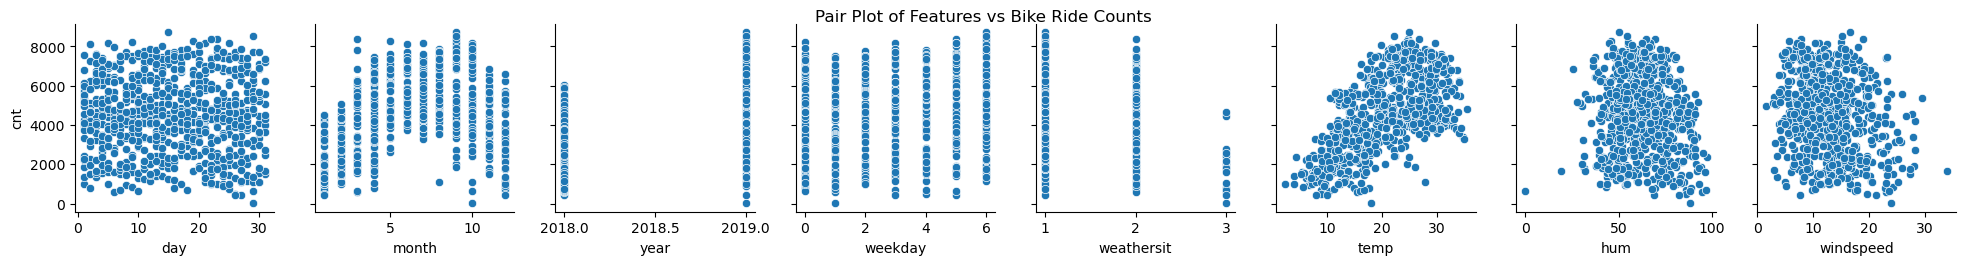

In [315]:
plt.figure(figsize=(15, 10))
sb.pairplot(df, x_vars=features_to_plot, y_vars='cnt', height=2.5)
plt.suptitle('Pair Plot of Features vs Bike Ride Counts', y=1.02)
plt.show()

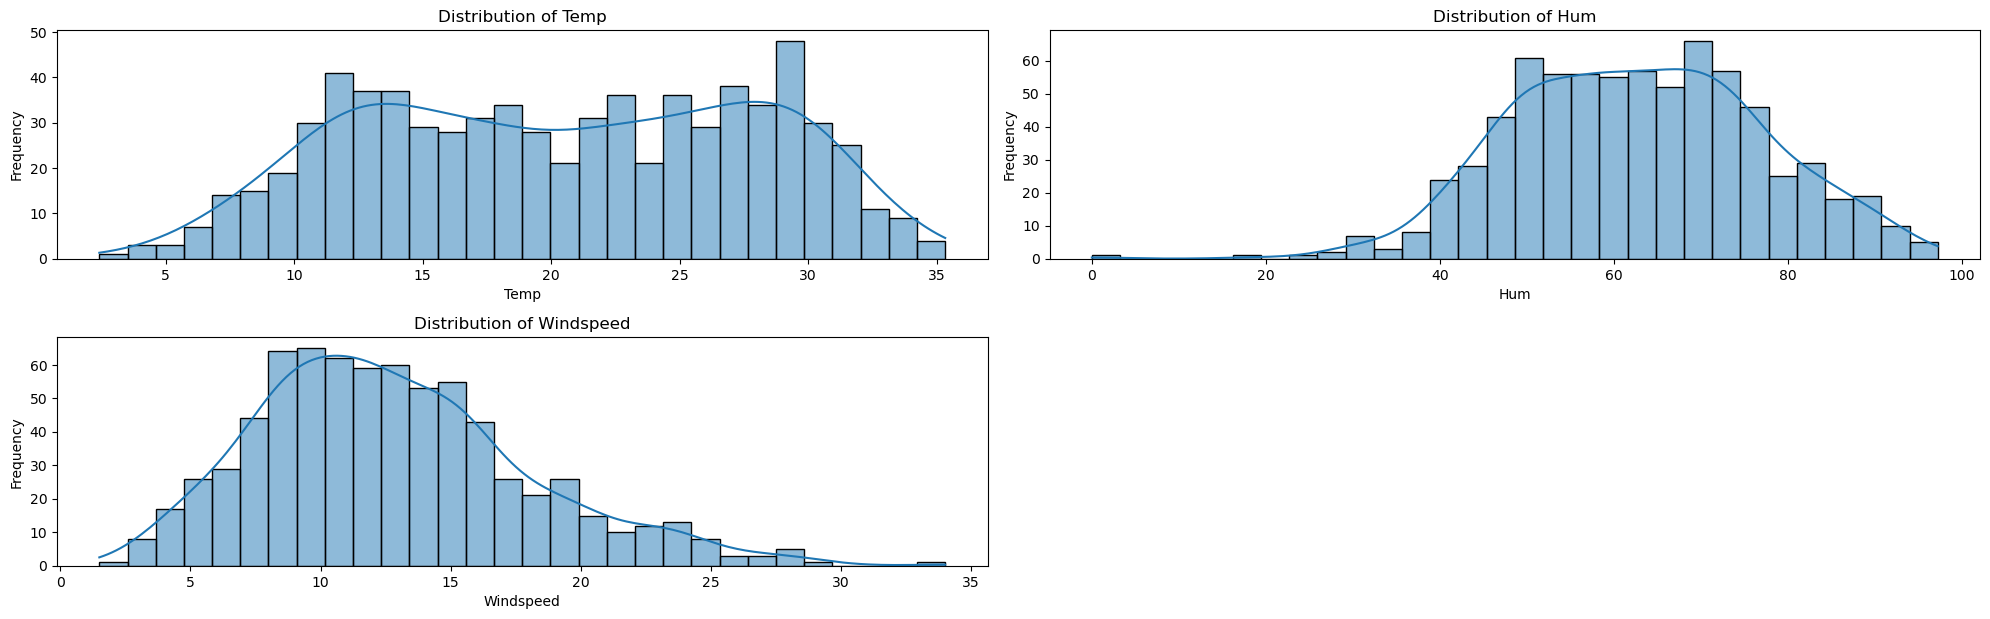

In [316]:
plt.figure(figsize=(20, 12))
for i, feature in enumerate(['temp', 'hum', 'windspeed'], 1):
    plt.subplot(4, 2, i)
    sb.histplot(df[feature], bins=30, kde=True)
    plt.title(f'Distribution of {feature.capitalize()}')
    plt.xlabel(feature.capitalize())
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

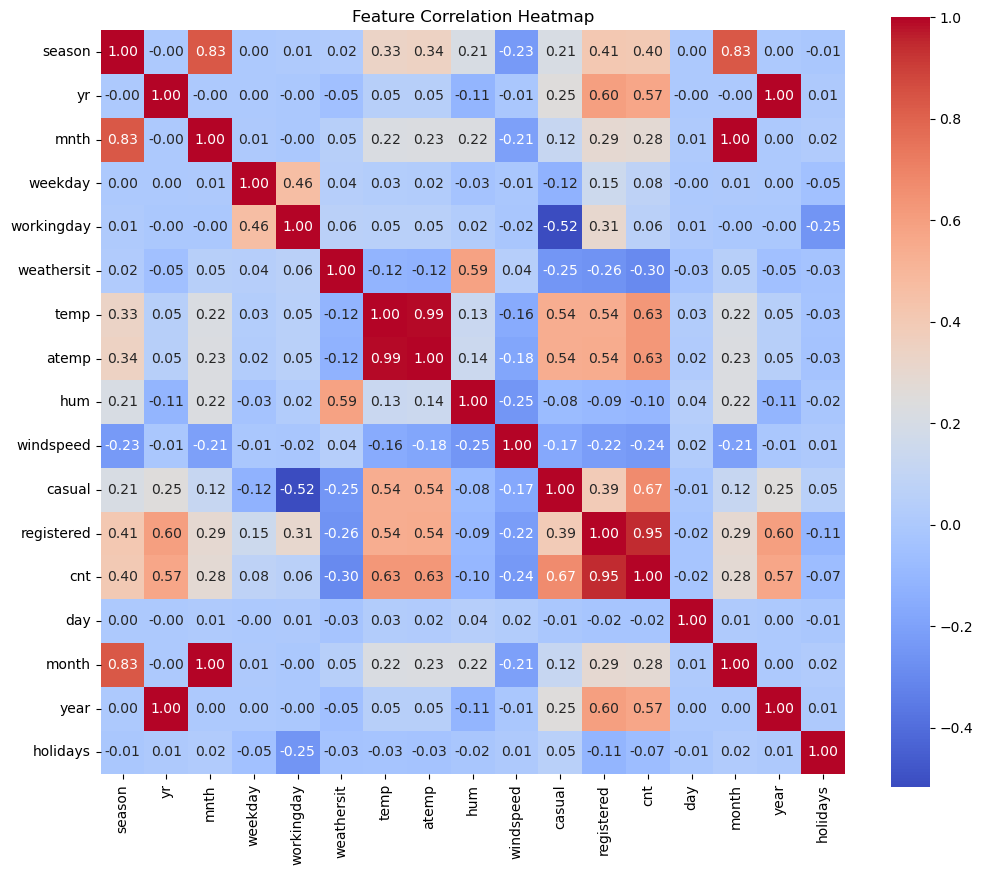

In [317]:
plt.figure(figsize=(12, 10))
corr = df.corr()
sb.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', square=True, cbar=True)
plt.title('Feature Correlation Heatmap')
plt.show()

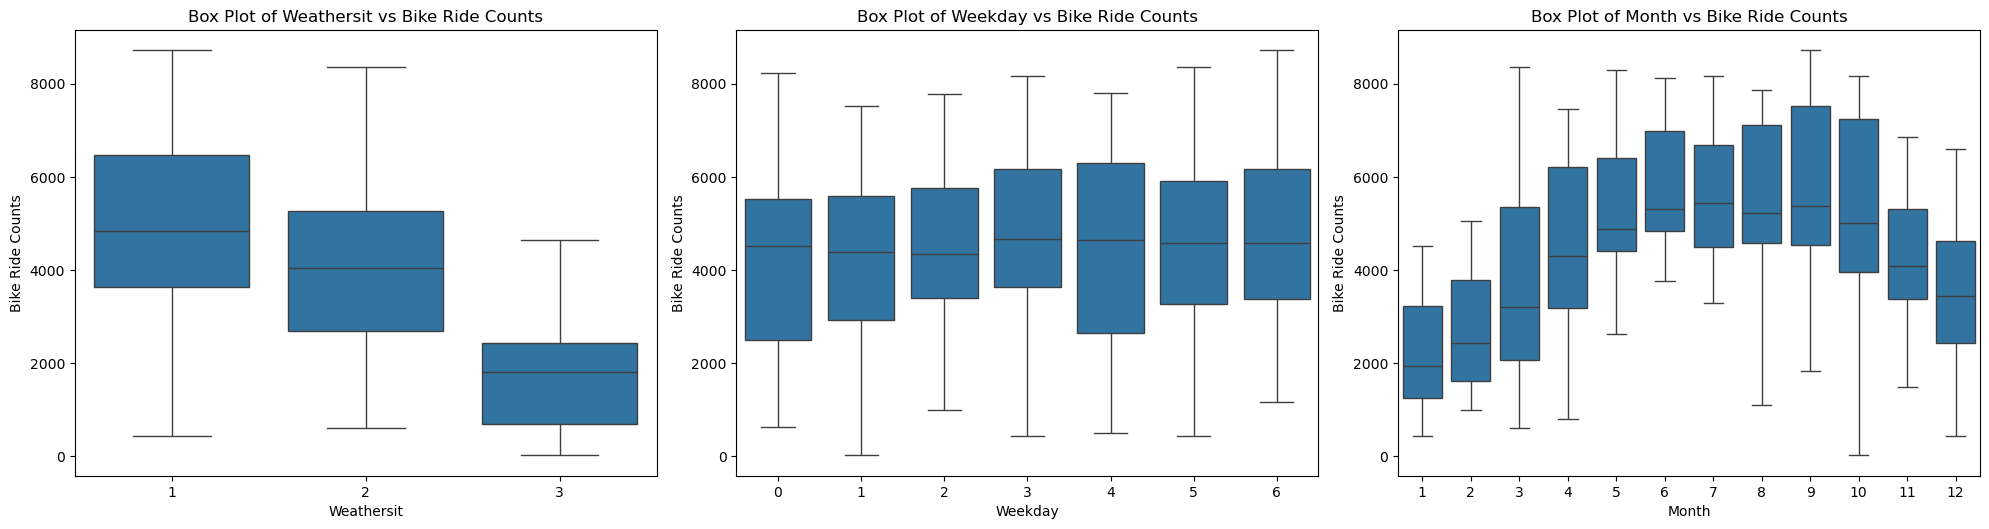

In [318]:
plt.figure(figsize=(20, 10))
for i, feature in enumerate(['weathersit', 'weekday', 'month'], 1):
    plt.subplot(2, 3, i)
    sb.boxplot(x=feature, y='cnt', data=df)
    plt.title(f'Box Plot of {feature.capitalize()} vs Bike Ride Counts')
    plt.xlabel(feature.capitalize())
    plt.ylabel('Bike Ride Counts')

plt.tight_layout()
plt.show()

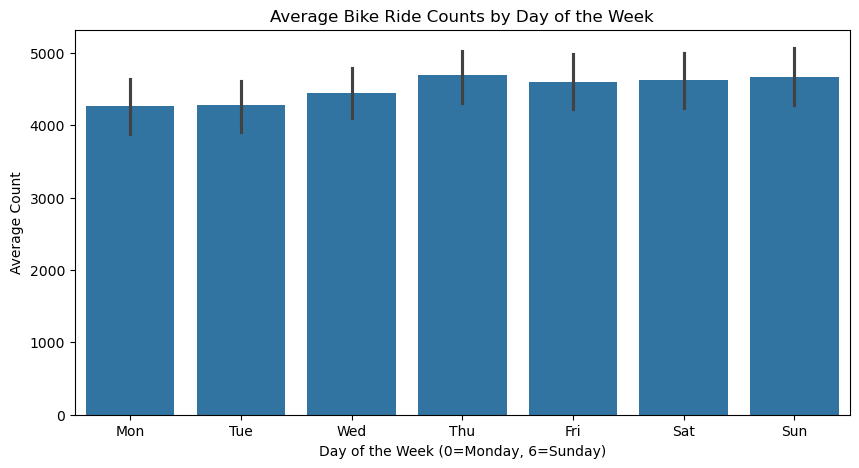

In [319]:
plt.figure(figsize=(10, 5))
sb.barplot(x='weekday', y='cnt', data=df, estimator=np.mean)
plt.title('Average Bike Ride Counts by Day of the Week')
plt.xlabel('Day of the Week (0=Monday, 6=Sunday)')
plt.ylabel('Average Count')
plt.xticks(ticks=np.arange(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

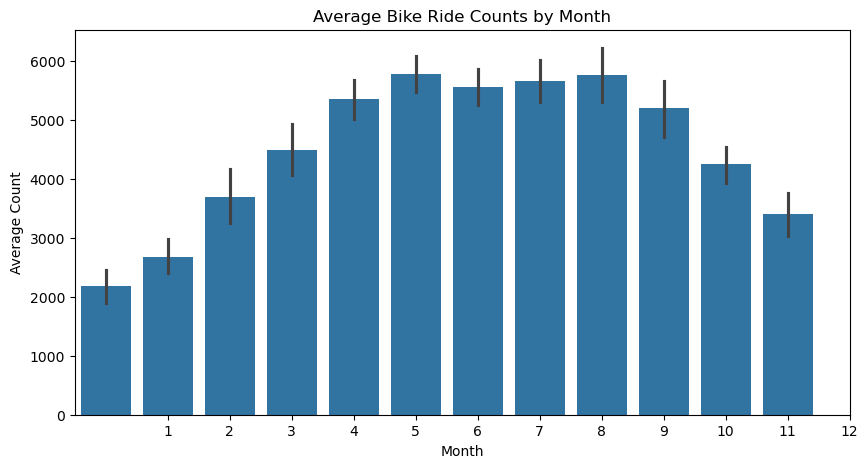

In [320]:
plt.figure(figsize=(10, 5))
sb.barplot(x='month', y='cnt', data=df, estimator=np.mean)
plt.title('Average Bike Ride Counts by Month')
plt.xlabel('Month')
plt.ylabel('Average Count')
plt.xticks(ticks=np.arange(1, 13), labels=[str(i) for i in range(1, 13)])
plt.show()

<p style="font-family:Verdana; font-size: 20px; color: orange"> Step 4: Data Preprocessing</p>

In [321]:
X = df.drop(['cnt'], axis=1)
y = df['cnt']
selector = RFE(estimator=RandomForestRegressor(), n_features_to_select=5)
selector.fit(X, y)
selected_features = X.columns[selector.support_]
print("Selected Features: ", selected_features)

Selected Features:  Index(['yr', 'atemp', 'windspeed', 'casual', 'registered'], dtype='object')


In [322]:
features = df[selected_features]
target = df['cnt'].values

In [323]:
X_train, X_val, Y_train, Y_val = train_test_split(features, target, test_size=0.1, random_state=22)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

models = [LinearRegression(), XGBRegressor(), Lasso(), RandomForestRegressor(), Ridge()]

<p style="font-family:Verdana; font-size: 20px; color: orange"> Step 5: Model Development</p>

In [324]:
for model in models:
    scores = cross_val_score(model, X_train, Y_train, cv=5, scoring='neg_mean_absolute_error')
    print(f'{model.__class__.__name__}: ')
    print('Cross-Validation MAE: ', -np.mean(scores))

    model.fit(X_train, Y_train)
    train_preds = model.predict(X_train)
    print('Training MAE: ', mae(Y_train, train_preds))
    print('Training MSE: ', mse(Y_train, train_preds))
    print('Training R²: ', r2_score(Y_train, train_preds))

    val_preds = model.predict(X_val)
    print('Validation MAE: ', mae(Y_val, val_preds))
    print('Validation MSE: ', mse(Y_val, val_preds))
    print('Validation R²: ', r2_score(Y_val, val_preds))
    print()


joblib.dump(model, 'best_model.pkl')

LinearRegression: 
Cross-Validation MAE:  9.165426019601577e-13
Training MAE:  6.845435769051948e-13
Training MSE:  8.438627177529176e-25
Training R²:  1.0
Validation MAE:  6.291709923223682e-13
Validation MSE:  8.0168531970036585e-25
Validation R²:  1.0

XGBRegressor: 
Cross-Validation MAE:  95.66089626985543
Training MAE:  2.659017124495368
Training MSE:  13.755342080545681
Training R²:  0.9999963641166687
Validation MAE:  79.5709011130137
Validation MSE:  15711.610828046521
Validation R²:  0.9949377775192261

Lasso: 
Cross-Validation MAE:  0.9776436810485274
Training MAE:  0.9707936841958157
Training MSE:  1.406866031881076
Training R²:  0.9999996311169068
Validation MAE:  0.9014197553621534
Validation MSE:  1.3637785405277754
Validation R²:  0.9999995605977762

RandomForestRegressor: 
Cross-Validation MAE:  74.76558697663661
Training MAE:  24.093789954337904
Training MSE:  1678.8033108066968
Training R²:  0.999559814407312
Validation MAE:  73.16835616438357
Validation MSE:  16130.5

['best_model.pkl']

<p style="font-family:Verdana; font-size: 20px; color: orange"> Step 6: Model Evaluation</p>

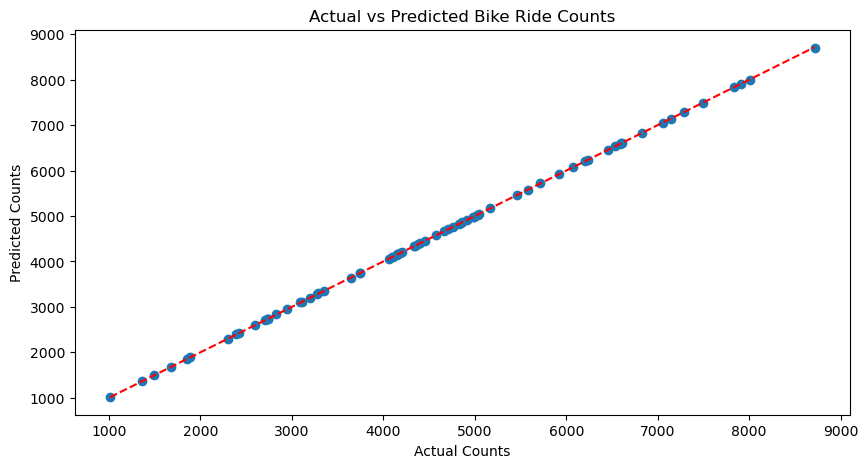

In [325]:
plt.figure(figsize=(10, 5))
plt.scatter(Y_val, val_preds)
plt.plot([Y_val.min(), Y_val.max()], [Y_val.min(), Y_val.max()], 'r--')
plt.xlabel('Actual Counts')
plt.ylabel('Predicted Counts')
plt.title('Actual vs Predicted Bike Ride Counts')
plt.show()

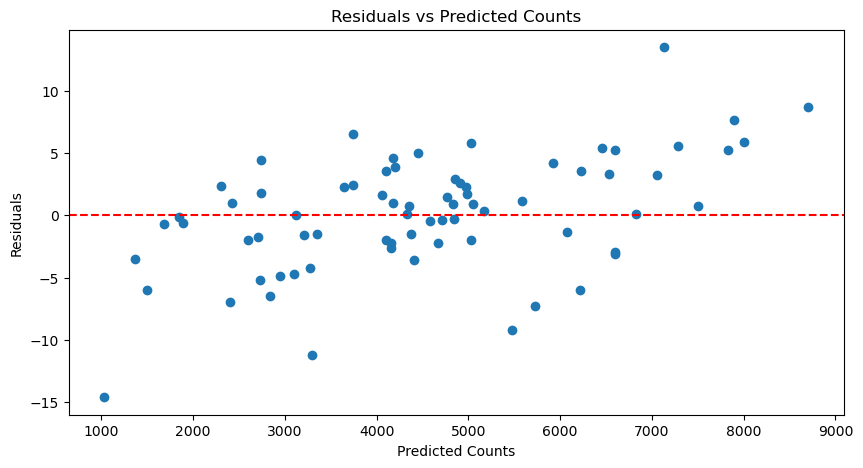

In [326]:
residuals = Y_val - val_preds
plt.figure(figsize=(10, 5))
plt.scatter(val_preds, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Counts')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Counts')
plt.show()